# Predict Next Purchase

In this example, we build a machine learning application that predicts whether customers will purchase a product within the next shopping period. This application is structured into three important steps:

* Prediction Engineering
* Feature Engineering
* Machine Learning

In the first step, we generate our own labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, we generate the features for labels by using [Featuretools](https://docs.featuretools.com/). In the third step, we search for the best machine learning pipeline for the features and labels by using [EvalML](https://evalml.alteryx.com/). After working through these steps, you will learn how to build machine learning applications for real-world problems like predicting consumer spending. Let's get started.

In [1]:
from demo.predict_next_purchase import load_sample
from evalml import AutoMLSearch
from evalml.preprocessing import split_data
import composeml as cp
import featuretools as ft
import matplotlib as mpl

We will use this historical data of online grocery orders provided by Instacart.

In [2]:
df = load_sample()

df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,order_time
id,,,,,,,,,,
0,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs,23750,2015-01-11 08:00:00
1,120,31323,7,0,Light Wisconsin String Cheese,21,16,dairy eggs,23750,2015-01-11 08:00:00
2,120,1503,8,0,Low Fat Cottage Cheese,108,16,dairy eggs,23750,2015-01-11 08:00:00
3,120,28156,11,0,Total 0% Nonfat Plain Greek Yogurt,120,16,dairy eggs,23750,2015-01-11 08:00:00
4,120,41273,4,0,Broccoli Florets,123,4,produce,23750,2015-01-11 08:00:00


## Prediction Engineering

> Will customers purchase a product within the next shopping period?

In this prediction problem, we have two parameters:

* The product that a customer can purchase.
* The length of the shopping period.

We can change these parameters to create different prediction problems. For example, will a customer purchase an avocado within the next day or a banana within the next 5 days? These variations can be done by simply tweaking the parameters. This helps us explore different scenarios which is crucial for making better decisions.


### Defining the Labeling Process

In each shopping period, we can check whether a customer bought a product. Let’s define this as a labeling function with a parameter for the product name.

In [3]:
def bought_product(ds, product_name):
    return ds.product_name.str.contains(product_name).any()

### Representing the Prediction Problem

We will represent the prediction problem using a label maker. This way, we can run searches on the historical orders to generate training examples. This is done by setting the following parameters:

* The `target_entity` as the customer, because we want to label orders for each individual customer.
* The `labeling_function` as the function we defined previously.
* The `time_index` as the order time, because shoppings periods are based on the order time.
* The `window_size` as the length of a shopping period. We can tweak this parameter to create variations of the prediction problem.

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='3d',
)

### Finding the Training Examples

Now, we can run a search to find purchases of the product within the shopping periods of each customer. This is done using the following parameters:

* The online grocery orders sorted by the order time.
* The `num_examples_per_instance` to find the number of training examples per customer. We search for all existing examples.
* The `product_name` as the product that we will check for purchases.
* The `minimum_data`  

The output from the search is a label times table with three columns:

* The user ID associated to the online grocery orders.
* The start time of the shopping period. This is also known as a cutoff time for building features. Only data that existed before the shopping period is valid to use for making predictions about the outcome.
* Whether or not the product was purchased in the shopping period. This is calculated by our labeling function.

In [5]:
lt = lm.search(
    df.sort_values('order_time'),
    num_examples_per_instance=-1,
    product_name='Banana',
    minimum_data='3d',
    verbose=False,
)

lt.head()

,user_id,time,bought_product
0,2555,2015-01-22 09:00:00,False
1,3283,2015-01-08 13:00:00,True
2,5360,2015-01-21 11:00:00,False
3,5669,2015-01-09 08:00:00,False
4,5669,2015-01-12 08:00:00,True


It can become difficult to track the parameters that were used to create the labels. As a helpful reference, we can look at the label description to understand how the labels were created from the start. The description also shows us the label distribution which we can check for imbalanced labels.


In [6]:
lt.describe()

Label Distribution
------------------
False     24
True      16
Total:    40


Settings
--------
gap                                    None
minimum_data                             3d
num_examples_per_instance                -1
target_column                bought_product
target_entity                       user_id
target_type                        discrete
window_size                              3d


Transforms
----------
No transforms applied



We can get a better look at the labels by plotting the distribution and the cumulative count across time.

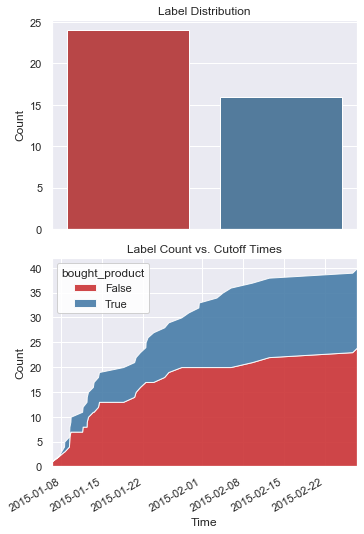

In [7]:
%matplotlib inline
fig = mpl.pyplot.figure(figsize=(5, 8))
ax0 = fig.add_subplot(211)
ax1 = mpl.pyplot.subplot(212)
fig.tight_layout()

lt.plot.distribution(ax=ax0)
lt.plot.count_by_time(ax=ax1);

## Feature Engineering

In the previous step, we generated the labels. The next step is to generate the features.

### Representing the Data

We will represent the online grocery orders using an entity set. This way, we can generate features based on the relational structure of the dataset. We currently have a single table of orders where one user can many orders. This one-to-many relationship can be represented in an entity set by normalizing an entity for the users. The same can be done for departments, aisles, products, and so on. Let's structure the entity set.

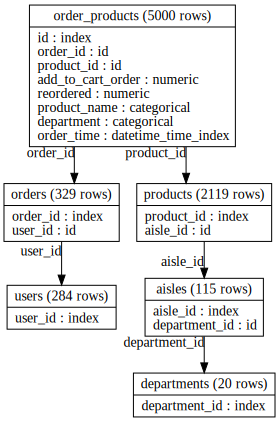

In [8]:
es = ft.EntitySet('instacart')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='order_products',
    time_index='order_time',
    index='id',
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='orders',
    index='order_id',
    additional_variables=['user_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='orders',
    new_entity_id='users',
    index='user_id',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='products',
    index='product_id',
    additional_variables=['aisle_id', 'department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='products',
    new_entity_id='aisles',
    index='aisle_id',
    additional_variables=['department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='aisles',
    new_entity_id='departments',
    index='department_id',
    make_time_index=False,
)

es["order_products"]["department"].interesting_values = ['produce']
es["order_products"]["product_name"].interesting_values = ['Banana']
es.plot()

### Calculating the Features

Now, we can generate features by using a method called Deep Feature Synthesis (DFS). This will automatically build features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Let’s run DFS using the following parameters:

* The `entity_set` as the entity set we structured previously.
* The `target_entity` as the user, because we want to generate features for each user. 
* The `cutoff_time` as the labels that we created previously. 

There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the calculated feature values based on cutoff times from our labels. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on new data.

In [9]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='users',
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

COUNT(orders)  \
user_id time                                 
2555    2015-01-22 09:00:00              2   
3283    2015-01-08 13:00:00              2   
5360    2015-01-21 11:00:00              2   
5669    2015-01-09 08:00:00              3   
        2015-01-12 08:00:00              3   

                             SUM(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                                      3   
3283    2015-01-08 13:00:00                                     28   
5360    2015-01-21 11:00:00                                    903   
5669    2015-01-09 08:00:00                                     66   
        2015-01-12 08:00:00                                    157   

                             SUM(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                              2   
3283    2015-01-08 13:00:00                              6   
5360    2015-01-21 11:00:00                             37   
5669    2015-01-09 08:00:00                              9   
        2015-01-12 08:00:00                             22   

                             STD(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                               0.707107   
3283    2015-01-08 13:00:00                               2.160247   
5360    2015-01-21 11:00:00                              12.267844   
5669    2015-01-09 08:00:00                               3.316625   
        2015-01-12 08:00:00                               3.599265   

                             STD(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                       0.000000   
3283    2015-01-08 13:00:00                       0.377964   
5360    2015-01-21 11:00:00                       0.327770   
5669    2015-01-09 08:00:00                       0.404520   
        2015-01-12 08:00:00                       0.282330   

                             MAX(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                                      2   
3283    2015-01-08 13:00:00                                      7   
5360    2015-01-21 11:00:00                                     42   
5669    2015-01-09 08:00:00                                     11   
        2015-01-12 08:00:00                                     13   

                             MAX(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                              1   
3283    2015-01-08 13:00:00                              1   
5360    2015-01-21 11:00:00                              1   
5669    2015-01-09 08:00:00                              1   
        2015-01-12 08:00:00                              1   

                             SKEW(order_products.add_to_cart_order)  \
user_id time                                                          
2555    2015-01-22 09:00:00                                     NaN   
3283    2015-01-08 13:00:00                                0.000000   
5360    2015-01-21 11:00:00                                0.000000   
5669    2015-01-09 08:00:00                                0.000000   
        2015-01-12 08:00:00                                0.072227   

                             SKEW(order_products.reordered)  \
user_id time                                                  
2555    2015-01-22 09:00:00                             NaN   
3283    2015-01-08 13:00:00                       -2.645751   
5360    2015-01-21 11:00:00                       -2.440735   
5669    2015-01-09 08:00:00                       -1.922718   
        2015-01-12 08:00:00                       -3

## Machine Learning

In the previous steps, we generated the labels and features. The final step is to build a machine learning pipeline.

### Splitting the Data

We will start by extracting the labels from the feature matrix and splitting the data into a training set and holdout set.

In [10]:
y = fm.pop('bought_product')
splits = split_data(fm, y, test_size=0.2, random_state=0)
X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Then, we run a search on the training set for the best machine learning model.

In [11]:
automl = AutoMLSearch(problem_type='binary', objective='f1', random_state=0)
automl.search(X_train, y_train, data_checks='disabled', show_iteration_plot=False)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: catboost, linear_model, random_forest, xgboost

(1/5) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.000
(2/5) CatBoost Classifier w/ Simple Imputer    Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.243
(3/5) XGBoost Classifier w/ Simple Imputer ... Elapsed:00:08
	Starting cross validation
	Finished cross validation - mean F1: 0.290
(4/5) Random Forest Classifier w/ Simple Im... Elapsed:00:12
	Starting cross validation
	Finished cross validation - mean F1: 0.370
(5/5) Logistic Regression Classifier w/ Sim... Elapsed:00:15
	Starting cross validation
	Finished cross validation - mean F1: 0.426

Search finished afte

****************************************************************************************
* Logistic Regression Classifier w/ Simple Imputer + One Hot Encoder + Standard Scaler *
****************************************************************************************

Problem Type: Binary Classification
Model Family: Linear

Pipeline Steps
1. Simple Imputer
	 * impute_strategy : most_frequent
	 * fill_value : None
2. One Hot Encoder
	 * top_n : 10
	 * categories : None
	 * drop : None
	 * handle_unknown : ignore
	 * handle_missing : error
3. Standard Scaler
4. Logistic Regression Classifier
	 * penalty : l2
	 * C : 1.0
	 * n_jobs : -1


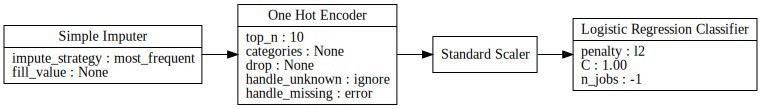

In [12]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Now, we can score the model performance by evaluating predictions on the holdout set.

In [13]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)
score = best_pipeline.score(X_holdout, y_holdout, objectives=['f1'])
dict(score)

{'F1': 0.8}